In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.clients.solana.meteora import SolanaMeteoraClient
from src.utils.analyzer import Analyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpl_dates
import pandas as pd
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick_ohlc

client = SolanaMeteoraClient()

Setting API URL: https://dlmm-api.meteora.ag
Setting RPC: https://api.mainnet-beta.solana.com
Creating session...
Session headers set: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/json', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'rpc': 'https://api.mainnet-beta.solana.com'}
Initialized MoralisPriceFetcher with API key: eyJh...
Fetching token symbols from CoinGecko...
Mapped 3801 Solana token addresses to symbols


# FETCH NEW LPs DATA

In [2]:
# Fetch and filter pools
pools = client.fetch_liquidity_pools()
min_tvl = 100000
min_volume = 50000
filtered_pairs = client.filter_pairs(pools, min_tvl=min_tvl, min_volume=min_volume)
print(f"Filtered pairs (TVL >= {min_tvl}, Volume >= {min_volume}): {len(filtered_pairs)}")
for pair in filtered_pairs:
    print(pair)

Fetching pools from https://dlmm-api.meteora.ag/pair/all
Status code: 200
Total pools in response: 71226
Sample pool: {'address': 'DDRmAJ9Tf8NvBJkPBg4xdvbkNfG9MyxhLwhJpZKqzkj1', 'name': 'KACY-SOL', 'mint_x': '6QSVGUEyBZWRshnXKhS96NQ97vGWiTu61SyHLAbYpump', 'mint_y': 'So11111111111111111111111111111111111111112', 'reserve_x': '9i8Por8VQZN6SmdkVYEsdsnPp2BkUz3Ggh6aKYmKqLqQ', 'reserve_y': 'Fer6hq4a6aUAprnk2y6xGtmZAwyo4ewucVPndtDbXbmX', 'reserve_x_amount': 0, 'reserve_y_amount': 23, 'bin_step': 15, 'base_fee_percentage': '0.15', 'max_fee_percentage': '0.976875', 'protocol_fee_percentage': '5', 'liquidity': '0', 'reward_mint_x': '11111111111111111111111111111111', 'reward_mint_y': '11111111111111111111111111111111', 'fees_24h': 0.0, 'today_fees': 0.0, 'trade_volume_24h': 0.0, 'cumulative_trade_volume': '932.9400', 'cumulative_fee_volume': '1.6300', 'current_price': 0.00010292084516820961, 'apr': 0.0, 'apy': 0.0, 'farm_apr': 0.0, 'farm_apy': 0.0, 'hide': False, 'is_blacklisted': False, 'fees':

In [3]:
# Filter for native token (SOL) and utility token pairs
native_utility_pairs = client.filter_native_utility_pairs(filtered_pairs)
print(f"Native-Utility pairs found: {len(native_utility_pairs)}")
for pair in native_utility_pairs:
    print(f"Native-Utility pair: {pair.token0_symbol}-{pair.token1_symbol} (TVL: {pair.tvl})")


Native-Utility pairs found: 0


### FIND LARGEST POOL FOR EACH SELECTED TOKEN

In [4]:
# Extract unique tokens and find largest SOL or USDC pool per token
token_to_pool = {}
for token in set(p.token0_address for p in filtered_pairs).union(p.token1_address for p in filtered_pairs):
    # Prefer SOL pool, then USDC if no SOL pool exists
    sol_pool = client.get_largest_pool(token, pools, base_token=client.SOL_ADDRESS)
    usdc_pool = client.get_largest_pool(token, pools, base_token=client.USDC_ADDRESS)
    largest_pool = sol_pool if sol_pool else usdc_pool
    if largest_pool:
        ticker = f"{largest_pool.token0_symbol}"
        base = f"{largest_pool.token1_symbol}"
        token_to_pool[token] = {
            "pair_address": largest_pool.address,
            "ticker": ticker,
            "base": base,
            "tvl": largest_pool.tvl
        }

tokens = set(token_to_pool.keys())
print(f"Tokens to analyze: {len(tokens)}")
print(token_to_pool)


Tokens to analyze: 17
{'61V8vBaqAGMpgDQi4JcAwo1dmBGHsyhzodcPqnEVpump': {'pair_address': '92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH', 'ticker': 'ARC', 'base': 'SOL', 'tvl': 499475.81102832226}, 'DezXAZ8z7PnrnRJjz3wXBoRgixCa6xjnB7YaB1pPB263': {'pair_address': '6oFWm7KPLfxnwMb3z5xwBoXNSPP3JJyirAPqPSiVcnsp', 'ticker': 'BONK', 'base': 'SOL', 'tvl': 943133.9824479066}, 'mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So': {'pair_address': '2dBPJGLgNDZnzA32452zV2u6vensbo28dveBvecDg6X1', 'ticker': 'MSOL', 'base': 'SOL', 'tvl': 34415.5515071018}, 'DgkKrQ1ErdRNjT2yTcAdEBa92JjFx75yxi4owArQarc': {'pair_address': 'CFtoEYSaBkLpP8mh4foXr9Cbw1YA23d2S25495B6sZVW', 'ticker': 'ASKJ', 'base': 'SOL', 'tvl': 16229.321539159919}, '9McvH6w97oewLmPxqQEoHUAv3u5iYMyQ9AeZZhguYf1T': {'pair_address': '6QBHzndsRpzuTxwDC2avVmQ6B291gM1sDx9oW9BfcFkE', 'ticker': 'ANON', 'base': 'SOL', 'tvl': 221513.659329784}, '4FkNq8RcCYg4ZGDWh14scJ7ej3m5vMjYTcWoJVkupump': {'pair_address': '6fqV5ieQ3wpZJYagS6BK2hKCV1HrfYbav5A7dHvxuSnn', 'ti

### CHOOSE OUTPUT DIRECTORY

In [5]:
# Set up output folder
output_dir = os.path.join(project_root, "price_data_1")
os.makedirs(output_dir, exist_ok=True)
print(f"Price data will be saved in: {output_dir}")

Price data will be saved in: C:\Users\Z640\dev\dex_analyzer\dex-analyzer\price_data_1


### FETCH OLHCV DATA FOR EACH TOKEN VS USD OR SOL

In [6]:
# Fetch and save price history with 1-hour timeframe
price_bars = []
from_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
to_date = datetime.now().strftime("%Y-%m-%d")

# change base to 'native' to get the prices in SOL, or to 'usd' to have it in dollars
base = "usd"

for token in tokens:
    pool_info = token_to_pool[token]
    pair_address = pool_info["pair_address"]
    ticker = pool_info["ticker"]
    
    pb = client.get_price_bars(pair_address, ticker, from_date, to_date, timeframe="4h",base_currency=base)
    
    if pb is None or pb.data is None:
        print(f"No data for {token}; skipping save.")
        continue

    # Save to pickle file
    if base == "usd":
        pickle_path = os.path.join(output_dir, f"{ticker}-USD.pkl")
    elif base == "native":
        pickle_path = os.path.join(output_dir, f"{ticker}-SOL.pkl")

    pb.data.to_pickle(pickle_path)
    print(f"Saved price data to {pickle_path}")
    
    price_bars.append(pb)

Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-27&toDate=2025-03-06&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 42 price bars for pair 92J3X46dbnoPs25Vc3fr5m1xt9GVrQddqiPD9uzXQHH (ticker: ARC, timeframe: 4h)
Saved price data to C:\Users\Z640\dev\dex_analyzer\dex-analyzer\price_data_1\ARC-USD.pkl
Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/6oFWm7KPLfxnwMb3z5xwBoXNSPP3JJyirAPqPSiVcnsp/ohlcv?timeframe=4h&baseCurrency=usd&fromDate=2025-02-27&toDate=2025-03-06&limit=100
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 42 price bars for pair 6oFWm7KPLfxnwMb3z5xwBoXNSPP3JJyirAPqPSiVcnsp (ticker: BONK, timeframe: 4h)
Saved price data to C:\Users\Z640\dev\dex_analyzer\dex-analyzer\price_data_1\BONK-USD.pkl
Requesting page 1: https://solana-gateway.moralis.io/t


Price bar for first token (BONK vs usd):
                   timestamp      open      high       low     close  \
37 2025-02-27 16:00:00+00:00  0.000014  0.000014  0.000013  0.000013   
38 2025-02-27 12:00:00+00:00  0.000014  0.000014  0.000013  0.000014   
39 2025-02-27 08:00:00+00:00  0.000014  0.000014  0.000014  0.000014   
40 2025-02-27 04:00:00+00:00  0.000014  0.000014  0.000014  0.000014   
41 2025-02-27 00:00:00+00:00  0.000013  0.000014  0.000013  0.000014   

           volume  
37  196337.332577  
38  256230.299500  
39  192897.098745  
40  250496.730634  
41  179831.055600  


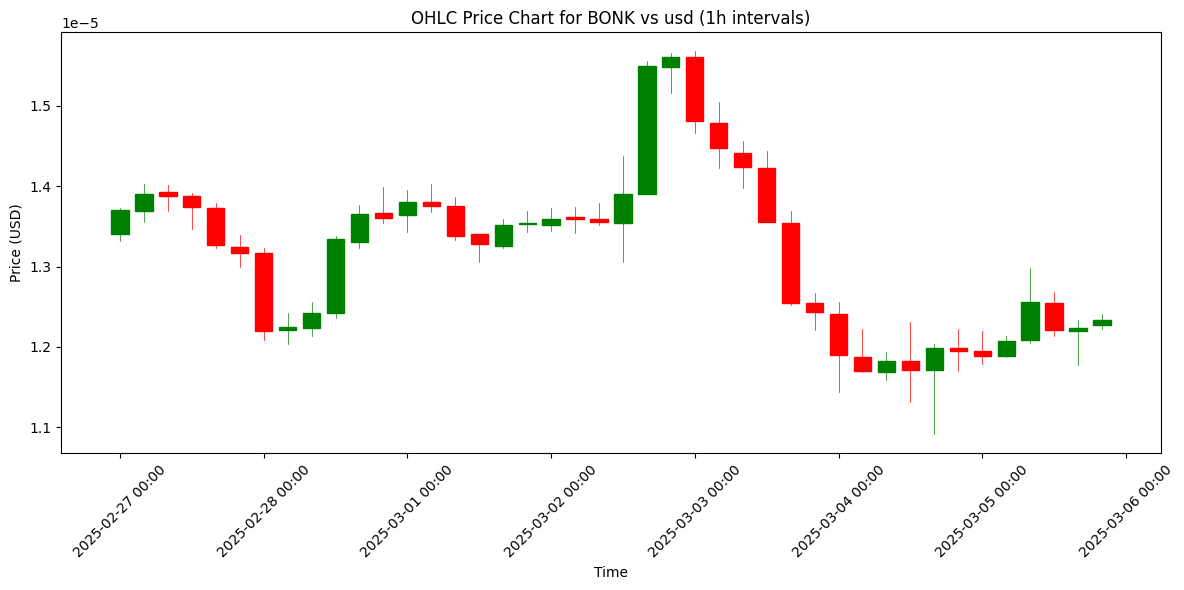

In [7]:
# Print and plot first price bar
if price_bars:
    first_token = price_bars[1]
    print(f"\nPrice bar for first token ({first_token.token_symbol} vs {first_token.base_token}):")
    print(first_token.data.tail())

    plot_data = first_token.data[["timestamp", "open", "high", "low", "close"]].copy()
    plot_data["timestamp"] = pd.to_datetime(plot_data["timestamp"])
    plot_data["timestamp"] = plot_data["timestamp"].map(pd.Timestamp.to_pydatetime).map(mpl_dates.date2num)

    fig, ax = plt.subplots(figsize=(12, 6))
    candlestick_ohlc(ax, plot_data.values, width=0.12, colorup='g', colordown='r')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    plt.title(f"OHLC Price Chart for {first_token.token_symbol} vs usd (1h intervals)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No price bars fetched")

# USE ALREADY FETCHED PRICE DATA

In [8]:
import sys
import os
import pandas as pd
import glob

project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

from src.models.price_bar import PriceBar
from src.utils.analyzer import Analyzer

# Directory containing pickle files
output_dir = os.path.join(project_root, "price_data_1")
print(f"Reading pickle files from: {output_dir}")

# Fetch all .pkl files
pickle_files = glob.glob(os.path.join(output_dir, "*.pkl"))
print(f"Found {len(pickle_files)} pickle files: {[os.path.basename(f) for f in pickle_files]}")

Reading pickle files from: C:\Users\Z640\dev\dex_analyzer\dex-analyzer\price_data_1
Found 16 pickle files: ['ANON-USD.pkl', 'ARC-USD.pkl', 'ASKJ-USD.pkl', 'BONK-USD.pkl', 'BSOL-USD.pkl', 'CBBTC-USD.pkl', 'FARTCOIN-USD.pkl', 'INF-USD.pkl', 'JITOSOL-USD.pkl', 'JLP-USD.pkl', 'JUP-USD.pkl', 'JUPSOL-USD.pkl', 'KMNO-USD.pkl', 'LUMO-USD.pkl', 'MSOL-USD.pkl', 'WBTC-USD.pkl']


## CALCULATE CORRELATION MATRIX

In [9]:
import os
from src.utils.analyzer import Analyzer

# Define the directory containing your pickle files
pickle_dir = os.path.join(project_root, "price_data_1")

# Collect a list of all .pkl file paths
pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl")
]

# Compute the correlation matrix directly from the pickle files.
corr_matrix = Analyzer.compute_correlation_matrix_from_pickle(pickle_files)

print("Correlation Matrix:")
display(corr_matrix)

Correlation matrix based on 35 overlapping timestamps
Correlation Matrix:


,ANON,ARC,ASKJ,BONK,BSOL,CBBTC,FARTCOIN,INF,JITOSOL,JLP,JUP,JUPSOL,KMNO,LUMO,MSOL,WBTC
ANON,1.000000,0.771328,0.770310,0.888980,0.646039,0.507089,0.602746,0.653543,0.651179,0.653042,0.840123,0.658750,0.819353,0.751956,0.665313,0.509112
ARC,0.771328,1.000000,0.996702,0.883011,0.502087,0.249250,0.743972,0.491895,0.488154,0.463649,0.873292,0.494390,0.887604,0.804594,0.503334,0.251063
ASKJ,0.770310,0.996702,1.000000,0.876689,0.485746,0.228729,0.735170,0.477234,0.473061,0.447774,0.879147,0.480127,0.880290,0.808635,0.489140,0.230563
BONK,0.888980,0.883011,0.876689,1.000000,0.762594,0.551863,0.694482,0.762215,0.756620,0.742355,0.945317,0.764318,0.952874,0.852990,0.766228,0.553761
BSOL,0.646039,0.502087,0.485746,0.762594,1.000000,0.866805,0.596465,0.992230,0.994469,0.983741,0.637117,0.993481,0.733053,0.709525,0.991958,0.864989
CBBTC,0.507089,0.249250,0.228729,0.551863,0.866805,1.000000,0.536010,0.882708,0.883592,0.922855,0.336266,0.888704,0.526901,0.425338,0.880785,0.998524
FARTCOIN,0.602746,0.743972,0.735170,0.694482,0.596465,0.536010,1.000000,0.586290,0.589811,0.607456,0.533578,0.596338,0.699250,0.629791,0.600236,0.536236
INF,0.653543,0.491895,0.477234,0.762215,0.992230,0.882708,0.586290,1.000000,0.999277,0.992957,0.635180,0.998953,0.738217,0.699124,0.996757,0.883903
JITOSOL,0.651179,0.488154,0.473061,0.756620,0.994469,0.883592,0.589811,0.999277,1.000000,0.992830,0.627771,0.999267,0.731434,0.699065,0.997331,0.884073
JLP,0.653042,0.463649,0.447774,0.742355,0.983741,0.922855,0.607456,0.992957,0.992830,1.000000,0.588602,0.993483,0.719766,0.650696,0.990600,0.923312


## CALCULATE BETA TO SOL

In [10]:

pickle_dir = os.path.join(project_root, "price_data_1")

sol_pickle = os.path.join(pickle_dir, "SOL-USD.pkl")

token_pickle_files = [
    os.path.join(pickle_dir, fname)
    for fname in os.listdir(pickle_dir)
    if fname.endswith(".pkl") 
]

# Compute beta for each token with respect to SOL
beta_results = Analyzer.compute_beta_with_sol(sol_pickle, token_pickle_files)

print("Beta values (relative to SOL):")
for token, beta in beta_results.items():
    print(f"{token}: {beta}")

[ERROR] Failed to load SOL pickle file 'C:\Users\Z640\dev\dex_analyzer\dex-analyzer\price_data_1\SOL-USD.pkl': [Errno 2] No such file or directory: 'C:\\Users\\Z640\\dev\\dex_analyzer\\dex-analyzer\\price_data_1\\SOL-USD.pkl'
Beta values (relative to SOL):


In [11]:
import sys
print(sys.executable)

c:\users\z640\appdata\local\programs\python\python39\python.exe


In [12]:
from dlmm import DLMM_CLIENT
import dlmm.dlmm as dlmm_module

# Update the API_URL to include the proper scheme
dlmm_module.API_URL = "https://dlmm-api.meteora.ag"

from solders.pubkey import Pubkey


# Replace with your actual user public key and RPC URL
user_pubkey = Pubkey.from_string("Yj7SzJwGkHuUKBfFytp8TPfj997ntSicCCuJLiB39kE")
rpc_url = "https://api.mainnet-beta.solana.com"


# Retrieve all LP positions for the user
positions = DLMM_CLIENT.get_all_lb_pair_positions_by_user(user_pubkey, rpc_url)



""" # Iterate over the returned dictionary to print out each position
for pool_address, position_info in positions.items():
    print(f"Pool: {pool_address}")
    for pos in position_info.lb_pair_positions_data:
        print(f"  Position Public Key: {pos.public_key}")
        print(f"    Total Token X: {pos.position_data.total_x_amount}")
        print(f"    Total Token Y: {pos.position_data.total_y_amount}")
        print(f"    Range: {pos.position_data.lower_bin_id} - {pos.position_data.upper_bin_id}") """


ModuleNotFoundError: No module named 'dlmm'